In [1]:
from numpy.random import normal
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
colorsss = ['royalblue', 'gold' , 'green', 'purple',  'cyan']
import sys

from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from scipy import ndimage
import pandas as pd
import seaborn as sns

In [2]:
module_path = 'demeter/'
sys.path.append(module_path)
import demeter

In [3]:
# Directory setup for custom modules
module_path = 'EagleEye/eagleeye'
sys.path.append(module_path)
import EagleEye
import From_data_to_binary

# Data generation

In [4]:
#test function to load gaia data -- reset median_ra and median_dec to
#test values around edges of survey 
#set parameters 
grid_size = 96
edge_size = 6
front = int(edge_size)
back  = int(grid_size-edge_size)

#center of the sky field in RA and DEC 
median_ra  = 2.5
median_dec = 0


#width of the field in gnomonic coordinates 
gnomonic_width = 0.0175

#width of the proper motion field 
pmfield_size = 5.0 

In [5]:
#load example gaia data and plot distributions 

data = pd.read_csv('demeter/data/gaia_example_data.csv')

#%plt.scatter(data['ra'], data['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
#%plt.xlabel('ra')
#%plt.ylabel('dec')
#%plt.title('position (Ra/Dec)')

#%plt.show()

#%plt.scatter(data['pmra'], data['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
#%plt.xlabel('pmra')
#%plt.ylabel('pmdec')
#%plt.title('proper motion')

#%plt.show()

parallax = data['parallax']

#%plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
#%plt.yscale('log')
#%plt.xlabel('parallax')
#%plt.title('parallax')

#%plt.show()



In [6]:
data = data.drop(['pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'g_rp','bp_g', 'bp_rp', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
                  'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                  'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error'], axis=1)


In [7]:
data.columns

Index(['Unnamed: 0', 'source_id', 'dec', 'ra', 'pmra', 'pmdec', 'parallax',
       'parallax_error'],
      dtype='object')

In [8]:
len(data)

119968

In [9]:
#apply position, proper motion, and parallax cuts 
#data_ref_cut = data 
data, x_ref, y_ref = demeter.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)
ref_field = np.c_[x_ref, y_ref, data['pmra'], data['pmdec']]


In [10]:
#check masking and gnomonic projection 
#%plt.scatter(data_ref_full['ra'], data_ref_full['dec'], c='grey',alpha=0.1, s=10,marker='*')
#%plt.scatter(data_ref_cut['ra'], data_ref_cut['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
#%plt.xlabel('ra')
#%plt.ylabel('dec')
#%plt.title('position (Ra/Dec)')
#%plt.show()


#%plt.scatter(x,y, c='midnightblue',alpha=1.,marker='*',s=60)
#%plt.xlim([-gnomonic_width,gnomonic_width])
#%plt.ylim([-gnomonic_width,gnomonic_width])
#%plt.title('position (Gnomonic)')


#%plt.show()
#%plt.scatter(data_ref_full['pmra'], data_ref_full['pmdec'], c='grey',alpha=0.1, s=10,marker='*')
#%plt.scatter(data_ref_cut['pmra'], data_ref_cut['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
#%plt.xlim([-pmfield_size,pmfield_size])
#%plt.ylim([-pmfield_size,pmfield_size])
#%plt.title('proper motion')

#%plt.show()

parallax = data['parallax']
#%plt.hist(data_ref_full['parallax'], bins = 20, range=(-10, 20), color='grey',alpha=0.1)
#%plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
#%plt.yscale('log')
#%plt.xlabel('parallax')
#%plt.title('parallax')

#%plt.show()

In [11]:
#test pipeline for simple gaussian "mock injection" 

#generate mock data 
xx_dwarf = normal(loc = -gnomonic_width/2, scale = gnomonic_width/20, size = 20)
yy_dwarf = normal(loc = -gnomonic_width/2, scale = gnomonic_width/20, size = 20)
pmra = normal(loc = -pmfield_size/2, scale = pmfield_size/20, size = 20)
pmdec = normal(loc = -pmfield_size/2, scale = pmfield_size/20, size = 20)

#xx = np.concatenate([xx, normal(loc = gnomonic_width/2, scale = gnomonic_width/20, size = 20)])
#yy = np.concatenate([yy, normal(loc = gnomonic_width/2, scale = gnomonic_width/20, size = 20)])
#pmra = np.concatenate([pmra, normal(loc = pmfield_size/2, scale = pmfield_size/20, size = 20)])
#pmdec = np.concatenate([pmdec, normal(loc = pmfield_size/2, scale = pmfield_size/20, size = 20)])

#%plt.scatter(x,y, c='midnightblue',alpha=.5,marker='*',s=60)
#%plt.scatter(xx,yy, c='salmon',alpha=1.,marker='*',s=60)
#%plt.xlim([-gnomonic_width,gnomonic_width])
#%plt.ylim([-gnomonic_width,gnomonic_width])
#%plt.title('position (Gnomonic)')

#%plt.show()

#transform data to Ra/Dec  
ra_inj, dec_inj = demeter.from_gnomonic(xx_dwarf ,yy_dwarf ,median_ra,median_dec)
#%plt.scatter(data_ref_cut['ra'],data_ref_cut['dec'],c='midnightblue',alpha=.5,marker='*',s=60)
#%plt.scatter(ra_inj, dec_inj, c='salmon',alpha=1.,marker='*',s=60)
#%plt.title('position (Ra/Dec)')

#%plt.show()

#%plt.scatter(data_ref_cut['pmra'],data_ref_cut['pmdec'],c='midnightblue',alpha=.5,marker='*',s=60)
#%plt.scatter(pmra, pmdec,  c='salmon',alpha=1.,marker='*',s=60)
#%plt.title('proper motion')

#%plt.show()

In [12]:
#inject stars into Gaia data and re-apply masking 
dwarf = pd.DataFrame(columns=data.keys())
for k in (data.keys()):
    dwarf[k] = np.ones(len(xx_dwarf))
dwarf['pmra']  = pmra
dwarf['pmdec'] = pmdec
dwarf['ra']    = ra_inj
dwarf['dec']   = dec_inj

data_dwarf = pd.concat([data, dwarf], axis = 0)

data_dwarf, x_dwarf, y_dwarf = demeter.mask_data(data_dwarf, median_ra, median_dec, gnomonic_width, pmfield_size)
full_field = np.c_[x_dwarf, y_dwarf, data_dwarf['pmra'], data_dwarf['pmdec']]


In [13]:
dwarf.columns

Index(['Unnamed: 0', 'source_id', 'dec', 'ra', 'pmra', 'pmdec', 'parallax',
       'parallax_error'],
      dtype='object')

# Demeter

In [14]:
#generate random comparison field 

#generate random field 
rand_x, rand_y, rand_pmra, rand_pmdec = demeter.make_random_image(data, x_ref, y_ref, gnomonic_width, pmfield_size)
random_field = np.c_[rand_x, rand_y, rand_pmra, rand_pmdec]


#%plt.scatter(rand_ra, rand_dec,c='midnightblue',alpha=.5,marker='*',s=60)
#%plt.xlim([-gnomonic_width,gnomonic_width])
#%plt.ylim([-gnomonic_width,gnomonic_width])
#%plt.title('position random field (gnomonic)')

#%plt.show()

#%plt.scatter(rand_pmra, rand_pmdec,c='midnightblue',alpha=.5,marker='*',s=60)

#%plt.title('proper motion random field ')
#%plt.xlim([-pmfield_size,pmfield_size])
#%plt.ylim([-pmfield_size,pmfield_size])
#%plt.show()


In [15]:
#generate histograms for wavelet transformation 



#generate histograms 
random_image, edges = demeter.make_field_image(random_field, gnomonic_width, pmfield_size, grid_size)
field_image, edges = demeter.make_field_image(full_field, gnomonic_width, pmfield_size, grid_size)

print(random_image.shape)

#plt.imshow(field_image.sum(axis=(0,1)), origin='upper')
#plt.show()
#plt.imshow(random_image.sum(axis=(0,1)), origin='upper')
#plt.show()

(96, 96, 96, 96)


In [16]:
#plot smoothed field before transformation 
smooth_field = scipy.ndimage.gaussian_filter(field_image,3.0)

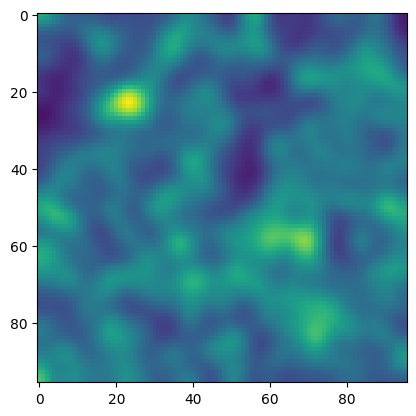

In [17]:
plt.imshow(smooth_field.sum(axis=(2,3))/np.max(smooth_field.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()


In [18]:
#run wavelet function on real and random field 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

wv = demeter.WaveNet(grid_size, grid_size, J=4, wavelets = ['bior5.5'])
out = wv(torch.Tensor(field_image).to(device)).to('cpu').numpy()
rand_out = wv(torch.Tensor(random_image).to(device)).to('cpu').numpy()

cpu


In [19]:
#apply smoothing 
out = scipy.ndimage.gaussian_filter(out,3.0)
rand_out = scipy.ndimage.gaussian_filter(rand_out,3.0)

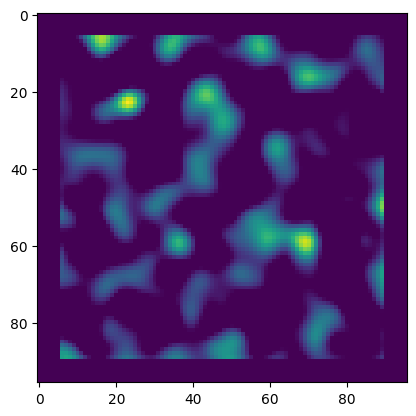

In [20]:
#remove outer edges of image 
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1

plt.imshow(out1.sum(axis=(2,3))/np.max(out1.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()

In [21]:
#standardize the real output 
out = (out-np.mean(rand_out))/np.std(rand_out)

In [22]:
#apply threshold 
edge_size = 6
front = int(edge_size)
back = int(grid_size-edge_size)
nstars = len(data)

#apply significance correction 
out = out / (-0.6*np.log10(nstars)+4.)

#applying thresholding 
mask = out < 5.0 
out[mask] = 0

#remove outer edges of image
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1


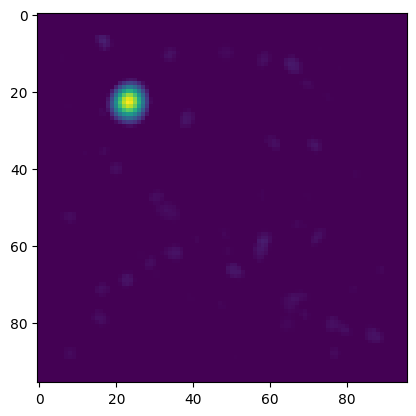

In [23]:
plt.imshow(out1.sum(axis=(2,3)))
plt.show()

In [24]:
#find remaining hotspots 
blobs, significance = demeter.find_blobs(out1, threshold=9)

In [25]:
print(blobs)
print(significance)

[[22.985665439242503, 23.380063124671224, 24.003024723829565, 24.66136244082062, 10.445262764911348, 9.730468119992507, 9.73709513366202, 11.44600717502097]]
[32.60344314575195]


In [26]:
#find clusters in original dataset 
clusters = demeter.find_clusters(data_dwarf, x_dwarf, y_dwarf, gnomonic_width, pmfield_size, grid_size, blobs)

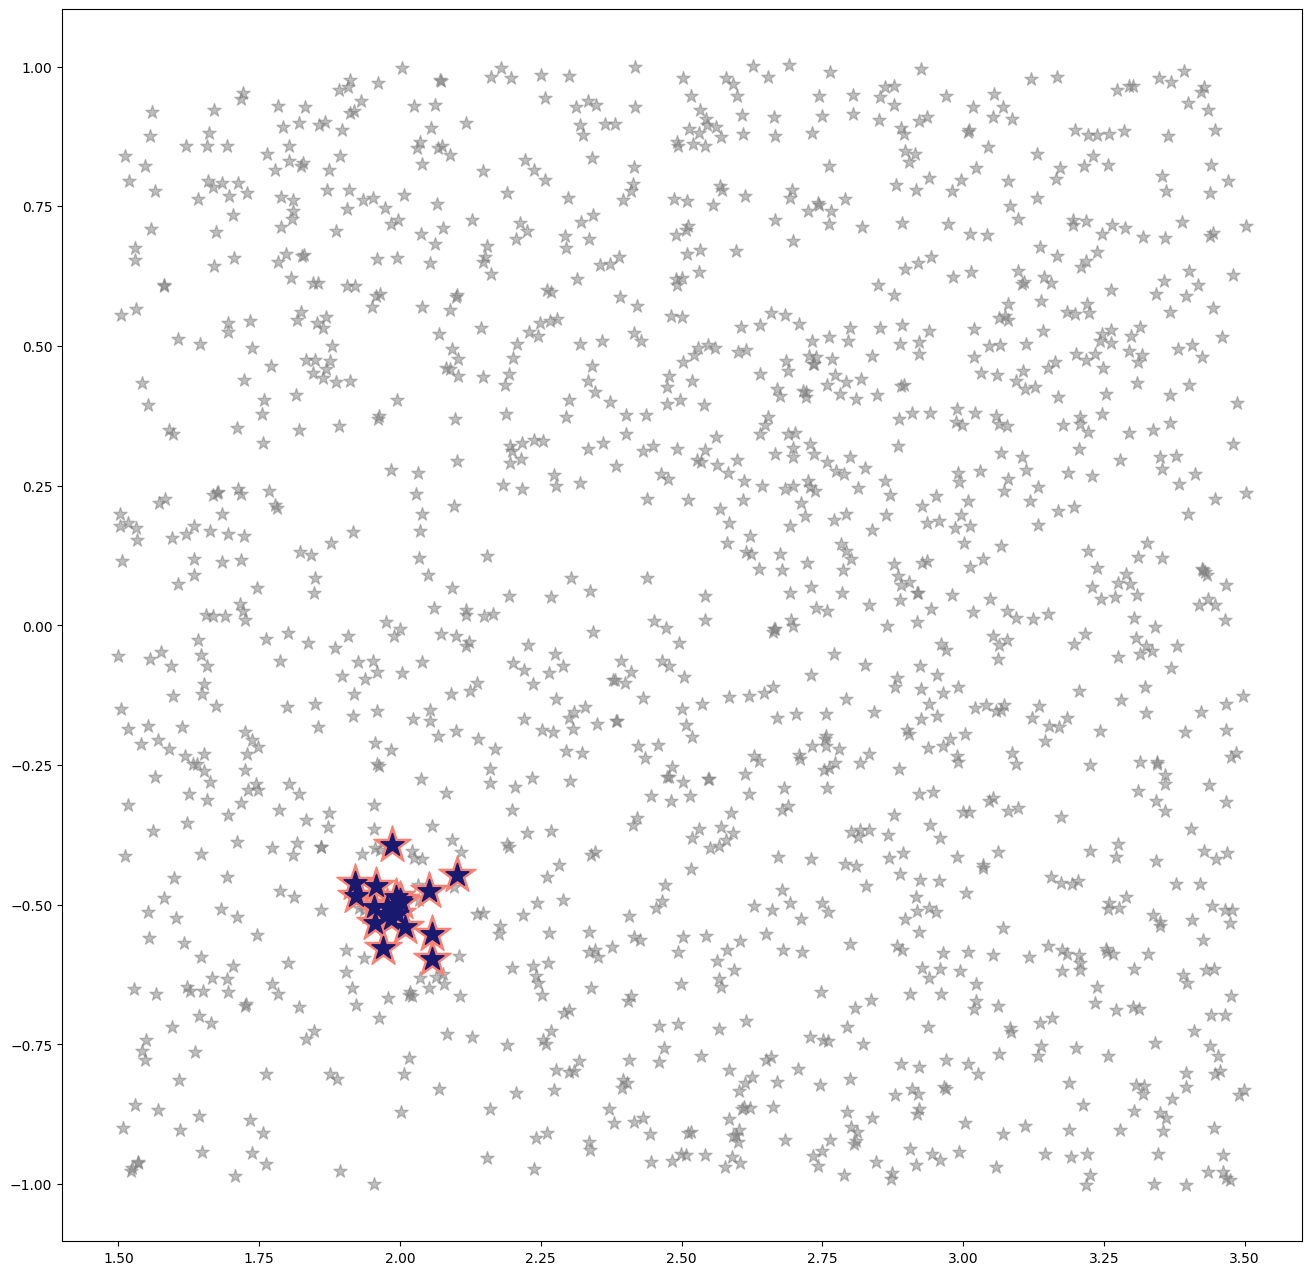

all injected stars recovered successfully!


In [27]:
fig, ax = plt.subplots(figsize=(16,16))

#plot background stars 
plt.scatter(data['ra'],data['dec'], alpha=0.5, color='grey', s=100, marker='*')

#plot injected stars 
plt.scatter(dwarf['ra'], dwarf['dec'], alpha=1., color='salmon',s=800, marker='*')

#plot returned stars
for cluster in clusters:
    if(len(cluster)>=5):
        plt.scatter(cluster['ra'], cluster['dec'], color='midnightblue',s=300, marker='*')

plt.show()

mask = np.isin(cluster['ra'], dwarf['ra'])

if(len(cluster[mask]==len(dwarf))):
    print('all injected stars recovered successfully!')

In [28]:
#calculate cluster poission significance 

#first filter field stars by cluster proper motio n
maxpmra = np.max(cluster['pmra'])
minpmra = np.min(cluster['pmra'])
maxpmdec = np.max(cluster['pmdec'])
minpmdec = np.min(cluster['pmdec'])

mask1 = data_dwarf['pmra'] <= maxpmra
mask2 = data_dwarf['pmra'] >= minpmra
mask3 = data_dwarf['pmdec'] <= maxpmdec
mask4 = data_dwarf['pmdec'] >= minpmdec
mask = mask1 & mask2 & mask3 & mask4
    
#calculate poisson rate for remaining stars 
poisson_rate = len(x_dwarf[mask])
x_clust, y_clust = demeter.to_gnomonic(cluster['ra'], cluster['dec'], median_ra, median_dec) 
area = (np.pi/4*(np.max(x_clust) - np.min(x_clust))*(np.max(y_clust) - np.min(y_clust)))/(4*gnomonic_width**2)

#calculate poisson significance 
poisson_int = (np.mean(scipy.stats.poisson(poisson_rate*area).rvs(10000)))
significance_poisson = ((len(cluster)-poisson_int)/np.sqrt(poisson_int))

print('wavelet significance: ' + str(np.round(significance[0], 2)))
print('poisson significance: ' + str(np.round(significance_poisson)))


wavelet significance: 32.6
poisson significance: 36.0


# EagleEye

In [29]:
# Function to compute the Upsilon (𝛶) values from binary sequences
def compute_upsilon_values(binary_sequences, neighbor_range, num_cores):
    """Calculates the Upsilon values for anomaly detection using p-values across a range of neighbors."""
    # Create a PValueCalculatorParallel instance to access both pval_array_dict and smallest_pval_info
    p_value_calculator = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range=neighbor_range, num_cores=num_cores)
    
    # Calculate Upsilon values (𝛶) as the negative log of minimum p-values
    p_value_data = p_value_calculator.smallest_pval_info
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    # Return both the calculator instance and the computed Upsilon values and k-star values
    return p_value_calculator, upsilon_values, kstar_values

# Function to retrieve Upsilon values for specific indices
def extract_upsilon_values(pval_info, indices, neighbor_range):
    """Extracts Upsilon values for given indices over a specified neighbor range."""
    return [[-np.log(pval_info.pval_array_dict[k][index, 0]) for k in neighbor_range] for index in indices]

# Function to find indices of interest based on Upsilon and k-star thresholds
def find_indices_by_threshold(upsilon_values, kstar_values, upsilon_thresh, kstar_thresh, condition='>'):
    """Finds indices where Upsilon and k-star values meet specified thresholds."""
    if condition == '>':
        indices = np.where((upsilon_values > upsilon_thresh) & (kstar_values < kstar_thresh))[0]
    else:
        indices = np.where((upsilon_values < upsilon_thresh) & (kstar_values > kstar_thresh))[0]
    return indices

In [30]:
# Function to plot the Upsilon sequences
def plot_nlpval(ax, nlpval1, nlpval2, nlpval3, label1, label2, label3,crit_v):
    ax.plot(range(4, len(nlpval1) + 4), nlpval1, color='limegreen', linewidth=2, label=label1)
    ax.plot(range(4, len(nlpval2) + 4), nlpval2, color='darkorange', linewidth=2, label=label2)
    ax.plot(range(4, len(nlpval3) + 4), nlpval3, color='magenta', linewidth=2, label=label2)
    # Apply logarithmic scale if necessary
    ax.set_yscale('log')
    # Highlight max values
    max_idx1 = np.argmax(nlpval1) + 4
    max_idx2 = np.argmax(nlpval2) + 4
    max_idx3 = np.argmax(nlpval3) + 4

    # ax.axvline(max_idx1, color='darkcyan', linestyle='--', linewidth=1.5, label=f'{label1} Kstar')
    # ax.axvline(max_idx2, color='red', linestyle='--', linewidth=1.5, label=f'{label2} Kstar')

    ax.axhline(y=crit_v, color='red', linestyle='--', linewidth=1.5, label='Crit. value')
    # ax.text(max_idx1, max(nlpval1), 'Kstar', color='darkcyan', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')
    # ax.text(max_idx2, max(nlpval2), 'Kstar', color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')

    arrowprops_settings = dict(facecolor='darkcyan', edgecolor='darkcyan', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx1, max(nlpval1)), xytext=(max_idx1, max(nlpval1) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings)

    arrowprops_settings_red = dict(facecolor='chocolate', edgecolor='chocolate', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx2, max(nlpval2)), xytext=(max_idx2, max(nlpval2) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_red)
    
    arrowprops_settings_mag = dict(facecolor='darkmagenta', edgecolor='darkmagenta', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx3, max(nlpval3)), xytext=(max_idx3, max(nlpval3) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_mag)

    # Add 'Crit. value' text above the critical value line
    ax.text(395, crit_v * 1.1, 'Crit. line', color='red', fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')


    ax.set_ylabel(r'$\Upsilon_i$', rotation=90)
    ax.set_xlim(0, 400-1)
    # ax.set_ylim(-5, max( [20, max(nlpval1), max(nlpval2)] )+10)
    ax.set_xlabel('K-nearest neighbors')
    # ax.legend(loc='upper right')



In [31]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences = 1000            # Number of Bernoulli sequences
K_M = 40                        # Length of each sequence
NUM_CORES = 1
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold

# Generate a Bernoulli matrix with sequences of 0s and 1s
bernoulli_sequences = np.random.binomial(n=1, p=0.5, size=(num_sequences, K_M))

# Compute Upsilon values and optimal k-star values for Bernoulli sequences
p_value_data, upsilon_values_bernoulli, optimal_kstar_bernoulli = compute_upsilon_values(bernoulli_sequences, neighbor_range=NEIGHBOR_RANGE, num_cores=NUM_CORES)

# Calculate the critical Upsilon threshold at the specified quantile
critical_upsilon_threshold = np.quantile(upsilon_values_bernoulli, critical_quantile)


Processing partition 1/1 completed.


In [32]:
critical_upsilon_threshold

10.080253083255196

In [33]:
data_dwarf_ar = np.array(data_dwarf[['ra','dec','pmra','pmdec']])
#%data_dwarf_ar = full_field

In [34]:
data_ref_ar = np.array(data[['ra','dec','pmra','pmdec']])
#%data_ref_ar = ref_field[:,:2] 

In [35]:
rand_ra, rand_dec = demeter.from_gnomonic(rand_x,rand_y,median_ra,median_dec)
data_rand_ar = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]
#%data_rand_ar = random_field[:,:2] 

In [51]:
rand_ra = np.random.choice(data_dwarf['ra'], len(data_dwarf), replace = False)
rand_dec = np.random.choice(data_dwarf['dec'], len(data_dwarf), replace = False)
data_rand_ar = np.c_[rand_ra, rand_dec, data_dwarf['pmra'], data_dwarf['pmdec']]


(-3.5, -1.9)

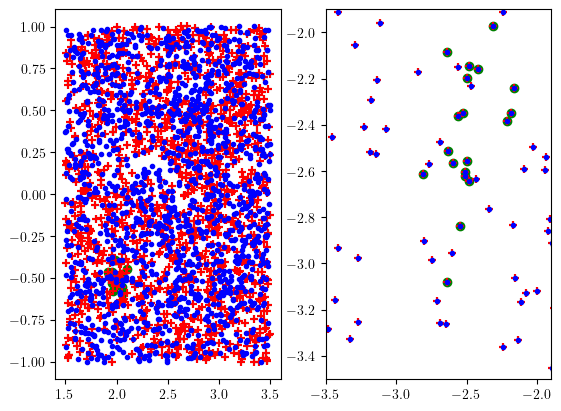

In [52]:
fig,ax = plt.subplots(1,2)

#ax[0].scatter(x_dwarf, y_dwarf, c = 'green')
ax[0].scatter(ra_inj, dec_inj, c = 'green')
ax[0].scatter(data_ref_ar[:,0], data_ref_ar[:,1], c = 'black', marker = '+')
ax[0].scatter(data_dwarf_ar[:,0], data_dwarf_ar[:,1], c = 'red', marker = '+')
ax[0].scatter(data_rand_ar[:,0], data_rand_ar[:,1], c = 'blue', marker = '.')

#%ax[0].set_xlim(-0.012, -0.006)
#%ax[0].set_ylim(-0.012, -0.006)

ax[1].scatter(pmra, pmdec, c = 'green')
ax[1].scatter(data_ref_ar[:,2], data_ref_ar[:,3], c = 'black', marker = '+')
ax[1].scatter(data_dwarf_ar[:,2], data_dwarf_ar[:,3], c = 'red', marker = '+')
ax[1].scatter(data_rand_ar[:,2], data_rand_ar[:,3], c = 'blue', marker = '.')
ax[1].set_xlim(-3.5, -1.9)
ax[1].set_ylim(-3.5, -1.9)

In [53]:
# Generate and process binary sequences with anomalies
binary_sequences_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_dwarf_ar, data_rand_ar, num_neighbors = K_M, num_cores = NUM_CORES
)
anomaly_pval_info, upsilon_values_anomaly, kstar_values_anomaly = compute_upsilon_values(
    binary_sequences_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

Processing partition 1/15
Processing partition 2/15
Processing partition 3/15
Processing partition 4/15
Processing partition 5/15
Processing partition 6/15
Processing partition 7/15
Processing partition 8/15
Processing partition 9/15
Processing partition 10/15
Processing partition 11/15
Processing partition 12/15
Processing partition 13/15
Processing partition 14/15
Processing partition 15/15
Processing partition 1/1 completed.


Text(0.5, 0, '$K_{*}^{dwarf}$')

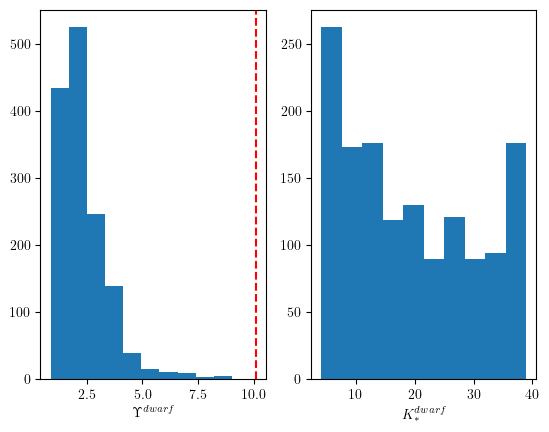

In [54]:
fig,ax = plt.subplots(1,2)

ax[0].hist(upsilon_values_anomaly)
ax[0].axvline(x = critical_upsilon_threshold, c = 'red', ls  = '--')
ax[0].set_xlabel('$\\Upsilon^{dwarf}$')

ax[1].hist(kstar_values_anomaly)
ax[1].set_xlabel('$K_{*}^{dwarf}$')


In [55]:
# Define indices of interest for anomaly data
positive_indices = find_indices_by_threshold(upsilon_values_anomaly, kstar_values_anomaly, 
                                             upsilon_thresh = 6, kstar_thresh = 30)
negative_indices = find_indices_by_threshold(upsilon_values_anomaly, kstar_values_anomaly, 
                                             upsilon_thresh = 3, kstar_thresh = 20, condition = '<')

# Collect Upsilon values for selected indices in anomaly data
upsilon_values_anomaly_selected = extract_upsilon_values(anomaly_pval_info, [positive_indices[0], 359, negative_indices[17]], NEIGHBOR_RANGE)

In [56]:
# Generate and process binary sequences without anomalies
binary_sequences_no_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_ref_ar, data_rand_ar, num_neighbors = K_M, num_cores = NUM_CORES
)
no_anomaly_pval_info, upsilon_values_no_anomaly, kstar_values_no_anomaly = compute_upsilon_values(
    binary_sequences_no_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

Processing partition 1/15
Processing partition 2/15
Processing partition 3/15
Processing partition 4/15
Processing partition 5/15
Processing partition 6/15
Processing partition 7/15
Processing partition 8/15
Processing partition 9/15
Processing partition 10/15
Processing partition 11/15
Processing partition 12/15
Processing partition 13/15
Processing partition 14/15
Processing partition 15/15
Processing partition 1/1 completed.


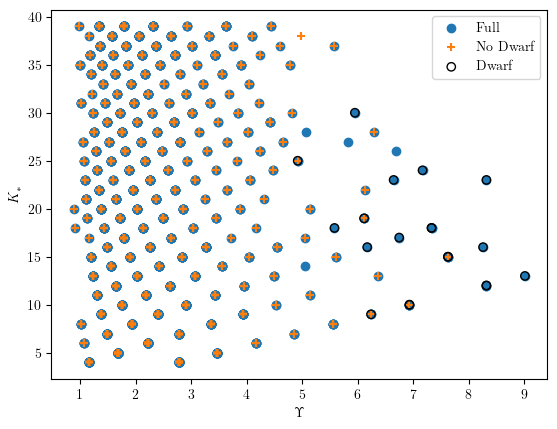

In [57]:
plt.scatter(upsilon_values_anomaly, kstar_values_anomaly, label = 'Full')
plt.scatter(upsilon_values_no_anomaly, kstar_values_no_anomaly, marker = '+', label = 'No Dwarf')
plt.scatter(upsilon_values_anomaly[-20:], kstar_values_anomaly[-20:], facecolors='none', edgecolors='black', marker = 'o', label = 'Dwarf')
plt.ylabel('$K_{*}$')
plt.xlabel('$\\Upsilon$')
plt.legend()

Text(0.5, 0, '$K_{*}$')

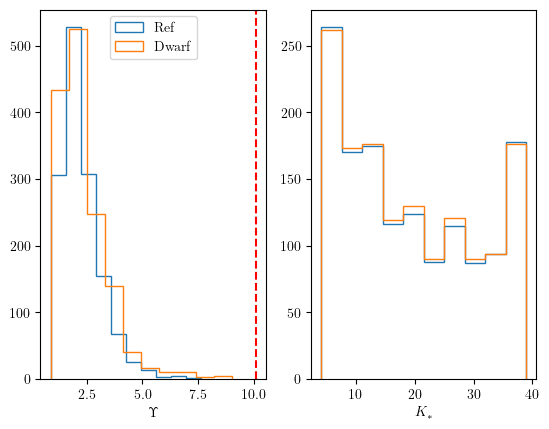

In [58]:
fig,ax = plt.subplots(1,2)

ax[0].hist(upsilon_values_no_anomaly, label = 'Ref', histtype = 'step')
ax[0].hist(upsilon_values_anomaly, label = 'Dwarf', histtype = 'step')
ax[0].axvline(x = critical_upsilon_threshold, c = 'red', ls  = '--')
ax[0].set_xlabel('$\\Upsilon$')
ax[0].legend()

ax[1].hist(kstar_values_no_anomaly, histtype = 'step')
ax[1].hist(kstar_values_anomaly, histtype = 'step')
ax[1].set_xlabel('$K_{*}$')

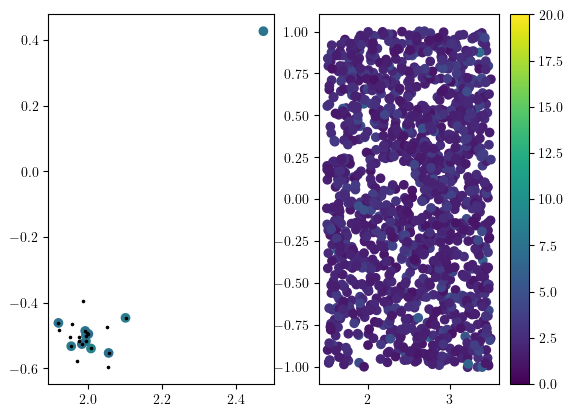

In [60]:
fig,ax = plt.subplots(1,2)
th = 7#critical_upsilon_threshold
ax[0].scatter(data_dwarf_ar[upsilon_values_anomaly > th,0], data_dwarf_ar[upsilon_values_anomaly > th,1], 
              c = upsilon_values_anomaly[upsilon_values_anomaly > th], marker = 'o', vmin = 0, vmax = 20)
#aux = Ellipse((np.mean(ra_inj), np.mean(dec_inj)), np.std(ra_inj), np.std(dec_inj), edgecolor='black',
#              facecolor='none', linewidth=2)
#ax[0].add_patch(aux)
#ax[0].scatter(xx_dwarf, yy_dwarf, facecolors='none', edgecolors='black', marker = 'o')
ax[0].scatter(ra_inj, dec_inj, marker = '.', c = 'black', s = 10)

#ax[0].set_xlim(-0.012, -0.006)
#ax[0].set_ylim(-0.012, -0.006)

im1 = ax[1].scatter(data_ref_ar[:,0], data_ref_ar[:,1], c = upsilon_values_no_anomaly, marker = 'o', vmin = 0, vmax = 20)
plt.colorbar(im1)
#ax[1].set_xlim(-0.012, -0.006)
#ax[1].set_ylim(-0.012, -0.006)

In [61]:
# Define indices of interest for no-anomaly data
no_anomaly_indices_a = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=7, kstar_thresh=50, condition='>')
no_anomaly_indices_b = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=6, kstar_thresh=18, condition='<')
no_anomaly_indices_c = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=2, kstar_thresh=20, condition='<')

# Collect Upsilon values for selected indices in no-anomaly data
upsilon_values_no_anomaly_selected = extract_upsilon_values(no_anomaly_pval_info, [no_anomaly_indices_a[0], no_anomaly_indices_b[17], no_anomaly_indices_c[10]], NEIGHBOR_RANGE)


In [62]:
index_positives_T = np.where((upsilon_values_anomaly > 5) & (np.array(kstar_values_anomaly) < 25))[0][7]
index_positives_F = 359 
index_negatives_q = np.where((upsilon_values_anomaly < 5) & (np.array(kstar_values_anomaly) > 20))[0][ 17]

NLPval_all3 = []
NLPval_all4 = []
NLPval_all5 = []
for j in range(4, K_M):
    NLPval_all3.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_positives_T, 0]))
    NLPval_all4.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_positives_F, 0]))
    NLPval_all5.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_negatives_q, 0]))
    
upsilon_values_anomaly_selected = [ np.array(NLPval_all3), np.array(NLPval_all4), np.array(NLPval_all5) ]


# index_negatives_ = np.where(NLPval_no_anomaly < 15)[0][[1631, 37, 77]]

index_negatives_a = np.where((upsilon_values_no_anomaly > 5) & (upsilon_values_no_anomaly < 11) 
                             & (np.array(kstar_values_no_anomaly) > 10))[0][ 1]
index_negatives_b = np.where((upsilon_values_no_anomaly > 2) & (upsilon_values_no_anomaly < 7) 
                             & (np.array(kstar_values_no_anomaly) < 21) & 
                             (np.array(kstar_values_no_anomaly) > 17) )[0][ 17]
index_negatives_c = np.where((upsilon_values_no_anomaly > 1) & (upsilon_values_no_anomaly < 3) 
                             & (np.array(kstar_values_no_anomaly) > 20))[0][ 10]

NLPval_all0 = []
NLPval_all1 = []
NLPval_all2 = []
for j in range(4, K_M):
    NLPval_all1.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_a, 0]))
    NLPval_all2.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_b, 0]))
    NLPval_all0.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_c, 0]))

upsilon_values_no_anomaly_selected = [ np.array(NLPval_all0), np.array(NLPval_all1), np.array(NLPval_all2) ]

Computation of distances started
Computation of the distances up to 10 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 1.9364081012095733
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 1.9311904907226562e-05 sec
Clustering finished, 1 clusters found
total time is, 0.00022602081298828125


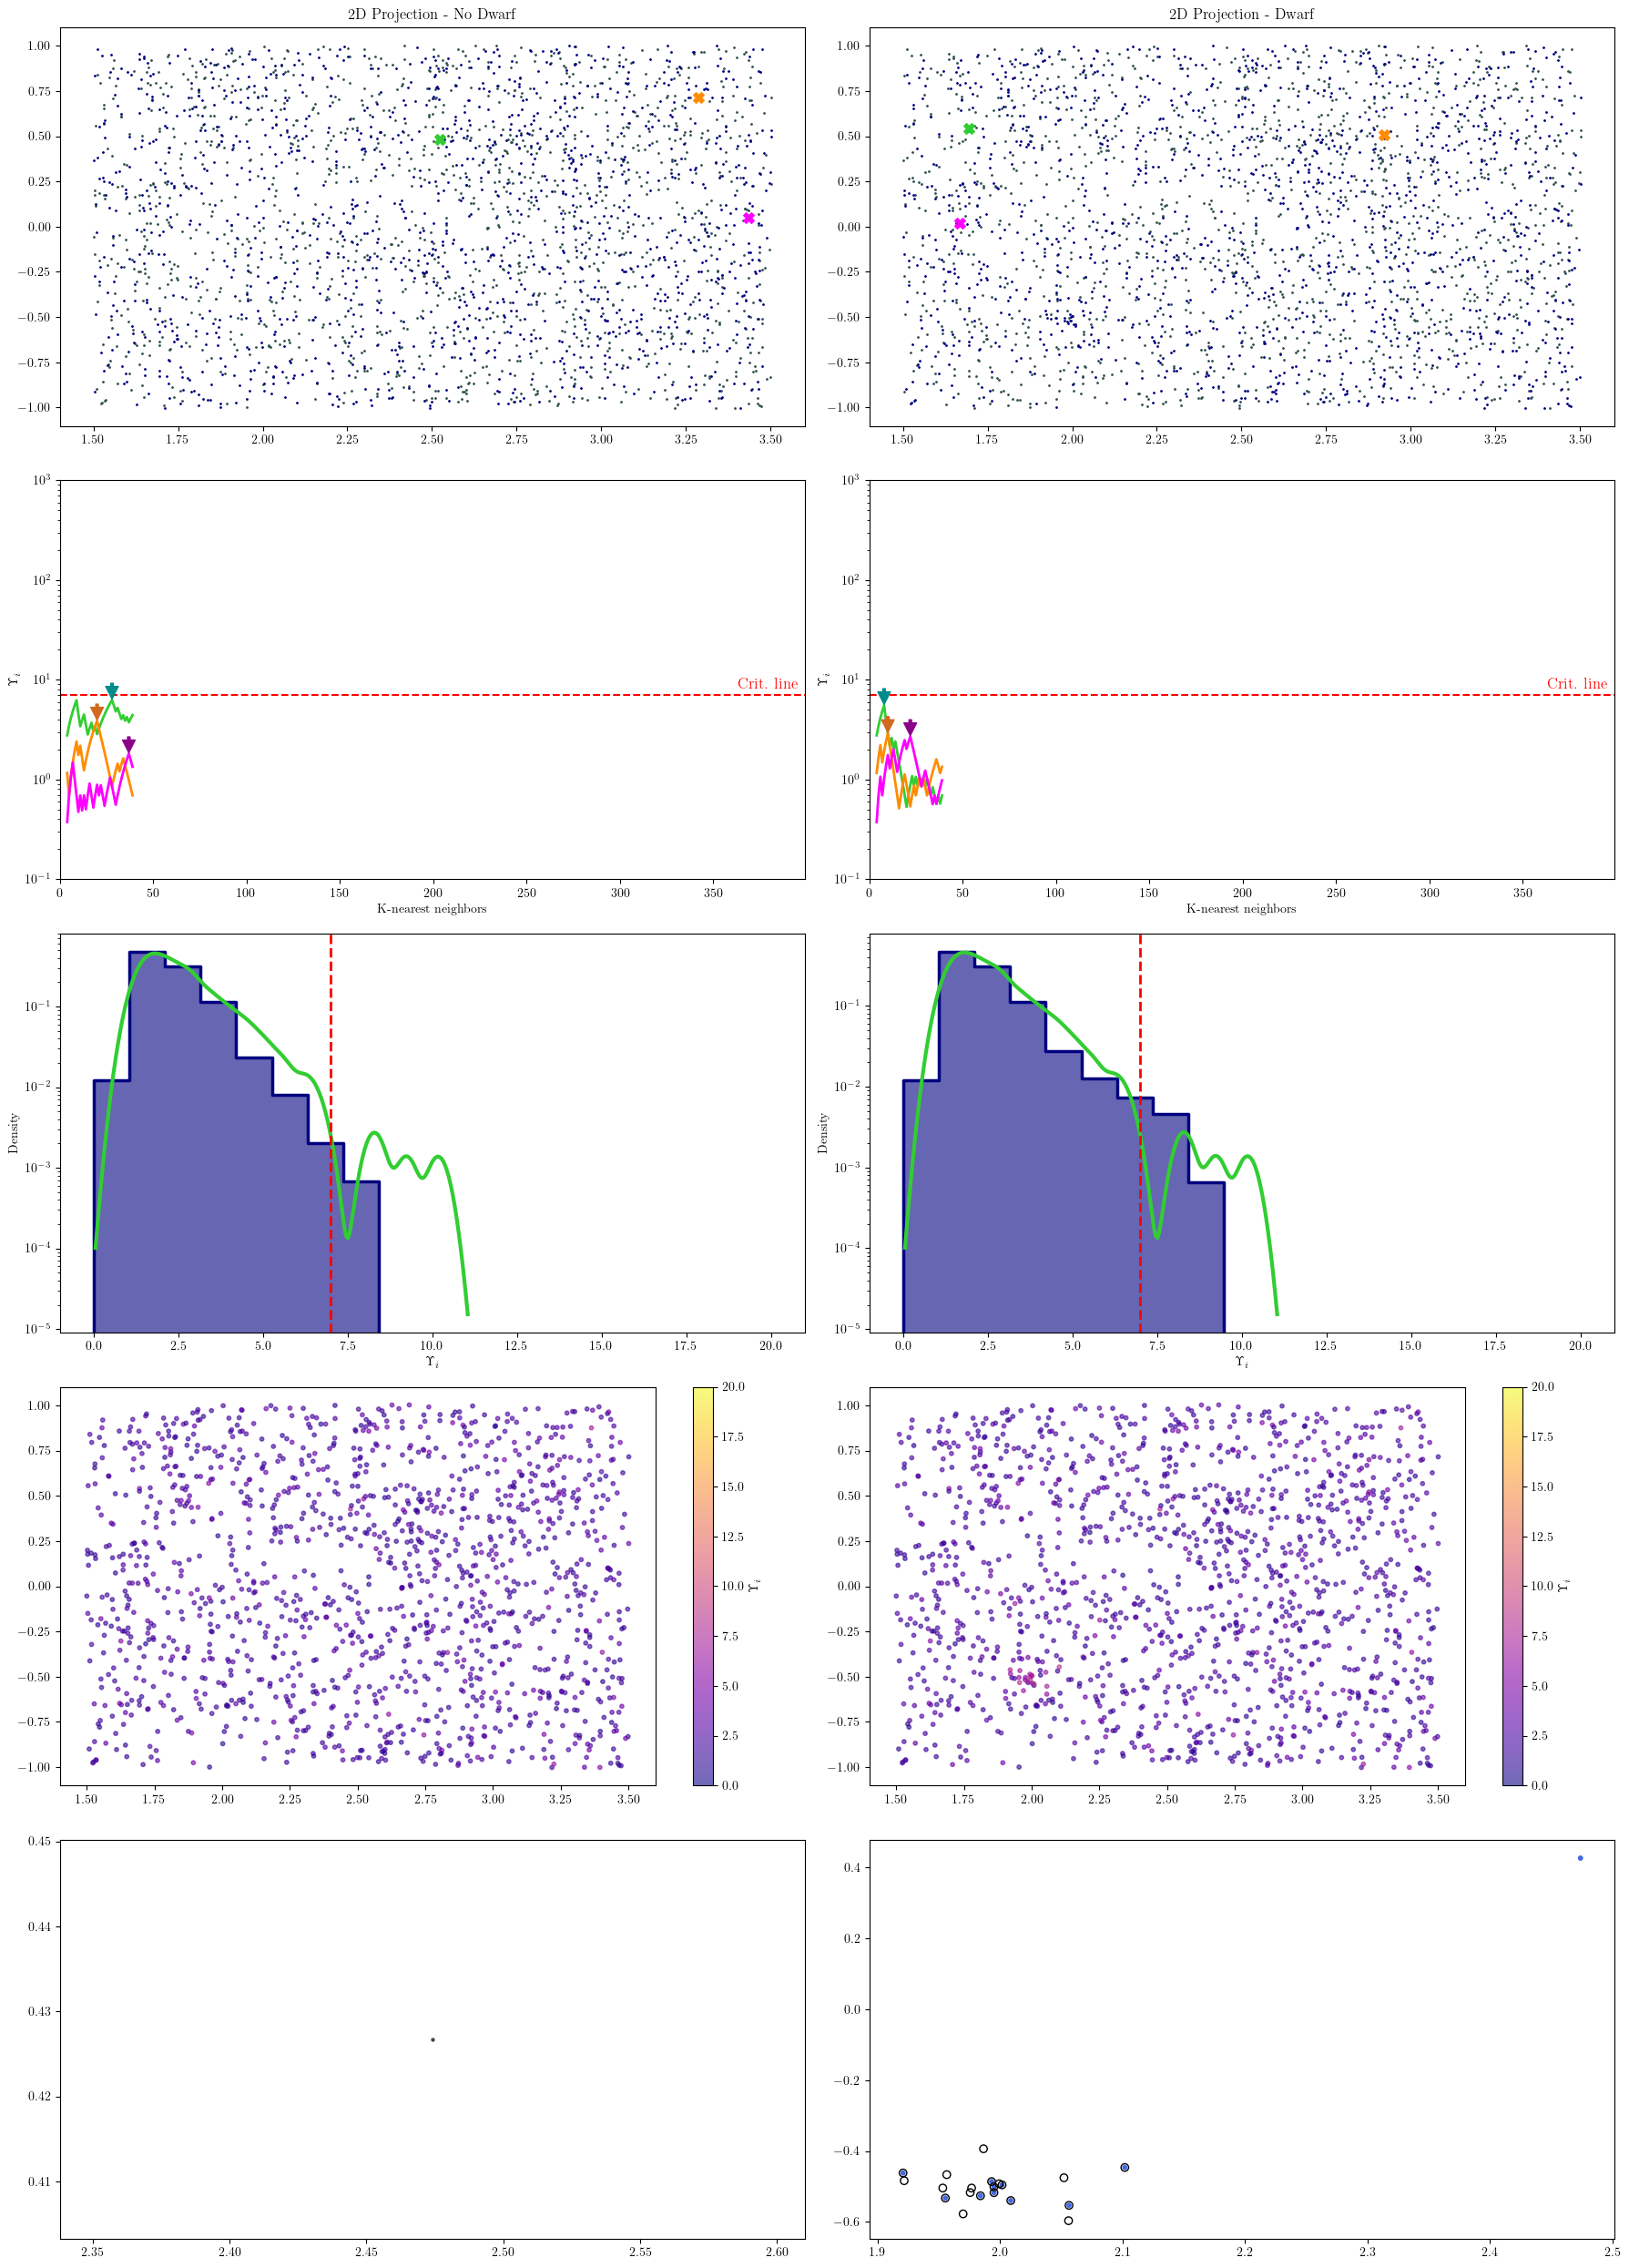

In [63]:
custom_rgb = (234 / 255, 234 / 255, 242 / 255)
axislim = [-4, 5]
crit_val = 7#critical_upsilon_threshold  # Example critical value


plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


# Set up the 5x2 grid for subplots
fig, axs = plt.subplots(5, 2, figsize=(18, 25))

# Scatter plots for no-anomaly and anomaly data in the first row
axs[0, 0].scatter(data_ref_ar[:,0], data_ref_ar[:,1], s=1.0, color='darkslategray', label='Reference')
axs[0, 0].scatter(data_rand_ar[:, 0], data_rand_ar[:, 1], s=1.0, color='navy', label='Data')
axs[0, 0].set_title('2D Projection - No Dwarf')
#axs[0, 0].set_xlim(-0.025,0.025)
#axs[0, 0].set_ylim(-0.025,0.025)

axs[0, 1].scatter(data_rand_ar[:, 0], data_rand_ar[:, 1], s=1.0, color='darkslategray', label='Reference')
axs[0, 1].scatter(data_dwarf_ar[:, 0], data_dwarf_ar[:, 1], s=1.0, color='navy', label='Data')
axs[0, 1].set_title('2D Projection - Dwarf')

# Row 2: Upsilon plots for no anomalies and with anomalies
plot_nlpval(axs[1, 0], upsilon_values_no_anomaly_selected[1], upsilon_values_no_anomaly_selected[2], 
            upsilon_values_no_anomaly_selected[0], label1='TN1', label2='TN2', label3='TN3', crit_v=crit_val)
axs[1, 0].set_ylim([1e-1, 1000])

plot_nlpval(axs[1, 1], upsilon_values_anomaly_selected[0], upsilon_values_anomaly_selected[1], 
            upsilon_values_anomaly_selected[2], label1='TP', label2='FP', label3='TN', crit_v=crit_val)
axs[1, 1].set_ylim([1e-1, 1000])


#%% add the points to the previous row
axs[0, 0].scatter(data_ref_ar[index_negatives_a, 0], data_ref_ar[index_negatives_a, 1], s=70.0, marker='X', c='limegreen', alpha=1, label='TN1')
axs[0, 0].scatter(data_ref_ar[index_negatives_b, 0], data_ref_ar[index_negatives_b, 1], s=70.0, marker='X',c='darkorange', alpha=1, label='TN2')
axs[0, 0].scatter(data_ref_ar[index_negatives_c, 0], data_ref_ar[index_negatives_c, 1], s=70.0, marker='X',c='magenta', alpha=1, label='TN3')
# axs[0, 0].legend()
axs[0, 1].scatter(data_dwarf_ar[index_positives_T, 0], data_dwarf_ar[index_positives_T, 1], s=70.0, marker='X',c='limegreen', alpha=1, label='TP')
axs[0, 1].scatter(data_dwarf_ar[index_positives_F, 0], data_dwarf_ar[index_positives_F, 1], s=70.0, marker='X',c='darkorange', alpha=1, label='FP')
axs[0, 1].scatter(data_dwarf_ar[index_negatives_q, 0], data_dwarf_ar[index_negatives_q, 1], s=70.0, marker='X',c='magenta', alpha=1, label='TN')
# axs[0, 1].legend()

# Row 3: Histograms of Upsilon distributions
sns.histplot(upsilon_values_no_anomaly, bins=np.linspace(0, 20, 20), kde=False, stat='density', label='No Anomaly', color='navy', element='step', linewidth=2.5, alpha=0.6, ax=axs[2, 0])
sns.kdeplot(upsilon_values_bernoulli, color='limegreen', linewidth=3, ax=axs[2, 0])
axs[2, 0].axvline(crit_val, color='red', linestyle='--', linewidth=2, label='Critical Value')
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel(r'$\Upsilon_i$')
#axs[2, 0].set_ylim([1e-4, 1e0])


sns.histplot(np.clip(upsilon_values_anomaly, a_min=None, a_max=40), bins=np.linspace(0, 20, 20), kde=False, stat='density', label='With Anomaly', color='navy', element='step', linewidth=2.5, alpha=0.6, ax=axs[2, 1])
sns.kdeplot(upsilon_values_bernoulli, color='limegreen', linewidth=3, ax=axs[2, 1])
axs[2, 1].axvline(crit_val, color='red', linestyle='--', linewidth=2, label='Critical Value')
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel(r'$\Upsilon_i$')
#axs[2, 1].set_ylim([1e-4, 1e0])

# Row 4: Color-coded scatter plots by Upsilon
sc1 = axs[3, 0].scatter(data_ref_ar[:, 0], data_ref_ar[:, 1], s=10.0, c=upsilon_values_no_anomaly
                        , cmap='plasma', alpha=0.6, vmin=0, vmax=20)
plt.colorbar(sc1, ax=axs[3, 0], label=r'$\Upsilon_i$')
sc2 = axs[3, 1].scatter(data_dwarf_ar[:, 0], data_dwarf_ar[:, 1], s=10.0, c=upsilon_values_anomaly
                        , cmap='plasma', alpha=0.6, vmin=0, vmax=20)
plt.colorbar(sc2, ax=axs[3, 1], label=r'$\Upsilon_i$')

# Row5: Clustering


X = data_dwarf_ar[upsilon_values_anomaly>crit_val,:]

data_aux = Data(X, verbose=True)
data_aux.compute_distances(maxk=10)
data_aux.compute_id_2NN()
data_aux.compute_density_kstarNN()
data_aux.compute_clustering_ADP(Z=2.65, halo=True)

Nclus_m = len(data_aux.cluster_centers)
cmap = plt.get_cmap("cool", Nclus_m)
mix_clustered_ = np.squeeze(X[data_aux.cluster_assignment[:] != -1,:])
mix_clustered_halo = np.squeeze(X[data_aux.cluster_assignment[:] == -1,:])

axs[4, 1].scatter(mix_clustered_halo[:,0],mix_clustered_halo[:,1], s=5.0, c='black', alpha=0.6)

# Find the unique number of clusters (ignoring any invalid cluster assignments like -1)
unique_clusters = sorted(set(data_aux.cluster_assignment[data_aux.cluster_assignment > -1]))

# Create a colormap using only as many colors as the number of unique clusters
cmap = ListedColormap(colorsss[:len(unique_clusters)])

# Create a BoundaryNorm that matches the number of clusters
norm = BoundaryNorm([i for i in range(len(unique_clusters)+1)], cmap.N)

sc = axs[4, 1].scatter(
mix_clustered_[:, 0],               # x-coordinates
mix_clustered_[:, 1],               # y-coordinates
s=10.0,                             # marker size
c=data_aux.cluster_assignment[data_aux.cluster_assignment > -1],  # Use cluster assignments directly
cmap=cmap,                           # Use the ListedColormap
norm=norm,                           # Normalize the colors
alpha=1   )                           # Transparency 
 
#axs[4, 1].set_xlim(axislim)
#axs[4, 1].set_ylim(axislim)


X = data_ref_ar[upsilon_values_no_anomaly>crit_val,:]
if X.shape[0]>10:
    data_aux = Data(X, verbose=True)
    data_aux.compute_distances(maxk= (len(X) - 2))
    data_aux.compute_id_2NN()
    data_aux.compute_density_kstarNN()
    data_aux.compute_clustering_ADP(Z=2.65, halo=True)
    
    Nclus_m = len(data_aux.cluster_centers)
    cmap = plt.get_cmap("cool", Nclus_m)
    mix_clustered_ = np.squeeze(X[data_aux.cluster_assignment[:] != -1,:])
    mix_clustered_halo = np.squeeze(X[data_aux.cluster_assignment[:] == -1,:])
    
    axs[4, 0].scatter(mix_clustered_halo[:,0],mix_clustered_halo[:,1], s=5.0, c='black', alpha=0.6)
    # Find the unique number of clusters (ignoring any invalid cluster assignments like -1)
    unique_clusters = sorted(set(data_aux.cluster_assignment[data_aux.cluster_assignment > -1]))
    
    # Create a colormap using only as many colors as the number of unique clusters
    cmap = ListedColormap(colorsss[:len(unique_clusters)])
    
    # Create a BoundaryNorm that matches the number of clusters
    norm = BoundaryNorm([i for i in range(len(unique_clusters)+1)], cmap.N)
    sc = axs[4, 1].scatter(
    mix_clustered_[:, 0],               # x-coordinates
    mix_clustered_[:, 1],               # y-coordinates
    s=10.0,                             # marker size
    c=data_aux.cluster_assignment[data_aux.cluster_assignment > -1],  # Use cluster assignments directly
    cmap=cmap,                           # Use the ListedColormap
    norm=norm,                           # Normalize the colors
    alpha=1   )    
    #axs[4, 0].set_xlim(axislim)
    #axs[4, 0].set_ylim(axislim)

else:
    axs[4, 0].scatter(X[:,0],X[:,1], s=5.0, c='black', alpha=0.6)
    #axs[4, 0].set_xlim(axislim)
    #axs[4, 0].set_ylim(axislim)
axs[4,1].scatter(ra_inj, dec_inj, facecolors='none', edgecolors='black', marker = 'o')

plt.tight_layout()
plt.show()

# Adding labels to each subplot
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
for ax, label in zip(axs[:,:].flat, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='left')

